## Fetch the local files

In [1]:
!wget -Nq https://raw.githubusercontent.com/copper-multigrid-conference/2019-tutorials/master/algebraic-multigrid/stencil.py
!wget -Nq https://raw.githubusercontent.com/copper-multigrid-conference/2019-tutorials/master/algebraic-multigrid/diffusion.py

## Import numpy, scipy, matplotlib

In [6]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
%matplotlib inline

import stencil
import diffusion

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Define the h-norm

The analog of
$$
\int_0^1 r(x) dx
$$
for discrete vector $r$ is
$$
\|r\|_h = h \|r\|_{\ell_2}
$$

In [3]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

## Define Jacobi relaxation, interpolation

In [7]:
def relaxJ(A, u, f, nu):
    """relax nu times on A u = f
    """
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 2.0 / 3.0
    
    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)

    return unew


def interpolation1d(nc, nf):
    """linear interpolation
    """
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

def create_operator(n, sten):
    """
    Create a 2D operator from a stencil.
    """
    A = stencil.stencil_grid(sten, (n, n), format='csr')
    return A

## A two grid cycle

In [8]:
def twogrid(A, P, A1, u0, f0, nu):
    
    # relax and restrict the residual
    u0 = relaxJ(A, u0, f0, nu)
    f1 = P.T * (f0 - A * u0)

    # coarse grid solve
    u1 = sla.spsolve(A1, f1)

    # interpolate, correct, and relax
    u0 = u0 + P * u1
    u0 = relaxJ(A, u0, f0, nu)
    return u0

### Run a two grid cycle
$$
-u_{xx} - \epsilon u_{yy} = f
$$

In [18]:
k = 6
n = 2**k - 1
nc = 2**(k-1) - 1

# matrix
# eps = 1
sten = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
# eps = 0.001 (and rotate)
# sten = diffusion.diffusion_stencil_2d(epsilon=0.001, theta=np.pi/40, type='FD')
A = (n+1)**2 * create_operator(n, sten)

# interpolation
P1d = interpolation1d(nc, n)
P = sparse.kron(P1d, P1d).tocsr()

# coarse level matrix
A1 = P.T * A * P

# the problem
x1d = np.linspace(0, 1, n+2)[1:-1]
X, Y = np.meshgrid(x1d, x1d)
ustar = (X**2 - X**4) * (Y**4 - Y**2)
f = 2 * ((1-6*X**2) * Y**2 * (1 - Y**2) + (1-6*Y**2) * X**2 * (1-X**2))
f = f.ravel()
u = np.random.rand(n*n)

res = [hnorm(f - A * u)]
for i in range(10):
    u = twogrid(A, P, A1, u, f, 2)
    res.append(hnorm(f - A * u))
    
res = np.array(res)
print(res[1:] / res[:-1])

[0.03028169 0.15183596 0.1705773  0.1783184  0.18262073 0.18533279
 0.1871847  0.18852272 0.18953171 0.19031861]


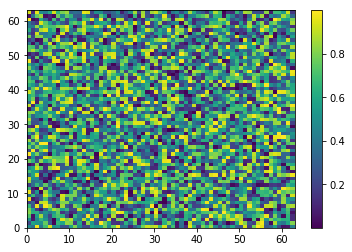

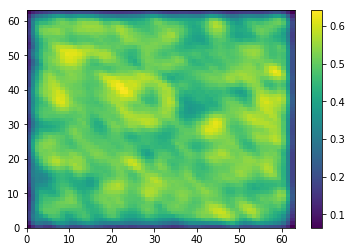

In [19]:
u = np.random.rand(n*n)
f = np.zeros((n*n,))
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()
u = relax(A, u, f, 4)
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()